In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
from utils.helper import get_news_scores, add_indicators, trim_df_columns, reg_model_metrics, get_complexity

### Data Preparation

In [3]:
df_stocks = pd.read_csv('data/jpm_bars_2024-02-20.csv')

In [4]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [5]:
df_stocks.tail()

open      high      low   close     volume  trade_count  \
date                                                                    
2024-02-12  174.78  176.8080  173.700  175.79  8539316.0      99614.0   
2024-02-13  175.32  176.2299  172.615  174.26  8397631.0     119866.0   
2024-02-14  175.07  176.1000  174.420  176.03  7056664.0      92056.0   
2024-02-15  176.15  180.2100  176.150  179.87  8723390.0     120899.0   
2024-02-16  179.61  179.9800  178.160  179.03  8292848.0      99541.0   

                  vwap  
date                    
2024-02-12  175.753564  
2024-02-13  174.170059  
2024-02-14  175.386226  
2024-02-15  179.302307  
2024-02-16  178.978772

### Engineering Features

In [6]:
#Add Indicators to stock dataframe
df_stocks_full = add_indicators(df_stocks)

LWMA
VIDYA
ALMA
MAMA
SWI
VORTEX


In [7]:
# Dropping columns with NaN values
df_stocks_full = trim_df_columns(df_stocks_full)

In [8]:
df_stocks_full.tail()

open      high      low   close     volume  trade_count  \
date                                                                    
2024-02-12  174.78  176.8080  173.700  175.79  8539316.0      99614.0   
2024-02-13  175.32  176.2299  172.615  174.26  8397631.0     119866.0   
2024-02-14  175.07  176.1000  174.420  176.03  7056664.0      92056.0   
2024-02-15  176.15  180.2100  176.150  179.87  8723390.0     120899.0   
2024-02-16  179.61  179.9800  178.160  179.03  8292848.0      99541.0   

                  vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
date                                                           
2024-02-12  175.753564            174.80          173.511210   
2024-02-13  174.170059            174.80          173.594409   
2024-02-14  175.386226            175.01          173.865030   
2024-02-15  179.302307            175.10          174.532249   
2024-02-16  178.978772            175.43          175.031999   

            EMA_9_period_EMA  ...  BASPN_Sell.    CMO_CMO   WTO_WT1.  \
date                          ...                                      
2024-02-12        174.674408  ...     0.966630  32.013929  47.492747   
2024-02-13        174.591526  ...     1.054888  10.996123  43.635535   
2024-02-14        174.879221  ...     0.960127  26.116263  45.456659   
2024-02-15        175.877377  ...     0.904087  47.581893  55.398224   
2024-02-16        176.507901  ...     0.912041  37.847702  60.870938   

             WTO_WT2.  FISH_10_period_FISH.  ICHIMOKU_TENKAN   APZ_UPPER  \
date                                                                       
2024-02-12  47.770033              0.651146         174.8650  180.968424   
2024-02-13  46.290644              0.451173         174.1190  180.929003   
2024-02-14  45.694599              0.669192         174.7115  181.176266   
2024-02-15  47.995791              1.045248         176.4125  182.071639   
2024-02-16  51.340339              1.474706         176.4125  182.677718   

             APZ_LOWER       VPT_VPT  STC_10_period_STC  
date                                                     
2024-02-12  171.272359  1.771103e+08           4.059616  
2024-02-13  171.200788  1.721854e+08           0.816851  
2024-02-14  171.446342  1.802502e+08           0.000000  
2024-02-15  172.286500  1.962359e+08           3.626752  
2024-02-16  172.867651  1.909504e+08          13.014950  

[5 rows x 95 columns]

In [9]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2016-01-25 to 2024-02-16
Data columns (total 95 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2031 non-null   float64
 1   high                                2031 non-null   float64
 2   low                                 2031 non-null   float64
 3   close                               2031 non-null   float64
 4   volume                              2031 non-null   float64
 5   trade_count                         2031 non-null   float64
 6   vwap                                2031 non-null   float64
 7   SMM_9_period_SMM                    2031 non-null   float64
 8   SSMA_9_period_SSMA                  2031 non-null   float64
 9   EMA_9_period_EMA                    2031 non-null   float64
 10  DEMA_9_period_DEMA                  2031 non-null   float64
 11  TEMA_9_period_TEMA               

In [10]:
# Check for NaNs
df_stocks_full.isnull().values.any()

False

In [11]:
df_news = pd.read_csv('data/jpm_news_2024-02-20.csv')

In [12]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)

In [13]:
df_news.tail()

headline  \
date                                                            
2024-02-09  AI Titans Meta, Microsoft, Nvidia Collaborate ...   
2024-02-11  From Steve Ballmer To Jamie Dimon, Meet The Bi...   
2024-02-12  JPMorgan Chase & Co. Reports Mixed Financial P...   
2024-02-13  What the Options Market Tells Us About JPMorga...   
2024-02-14  Here's How Much You Would Have Made Owning JPM...   

                                                      summary  \
date                                                            
2024-02-09  Gina Raimondo, Secretary of Commerce, says the...   
2024-02-11  Among American billionaires, a distinguished f...   
2024-02-12  As the financial world turns its eyes towards ...   
2024-02-13                                                      
2024-02-14                                                      

                                                          url news_type  \
date                                                                      
2024-02-09  https://www.benzinga.com/markets/equities/24/0...  POSITIVE   
2024-02-11  https://www.benzinga.com/news/24/02/37059392/f...  POSITIVE   
2024-02-12  https://www.benzinga.com/24/02/37077611/jpmorg...  NEGATIVE   
2024-02-13  https://www.benzinga.com/insights/options/24/0...  POSITIVE   
2024-02-14  https://www.benzinga.com/insights/news/24/02/3...  NEGATIVE   

               score                               symbols  
date                                                        
2024-02-09  0.996709  ['C', 'JPM', 'META', 'MSFT', 'NVDA']  
2024-02-11  0.998899               ['AAPL', 'JPM', 'MSFT']  
2024-02-12  0.651195                               ['JPM']  
2024-02-13  0.991712                               ['JPM']  
2024-02-14  0.988477                               ['JPM']

In [14]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4447 entries, 2015-01-02 to 2024-02-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   headline   4447 non-null   object 
 1   summary    1816 non-null   object 
 2   url        4447 non-null   object 
 3   news_type  4447 non-null   object 
 4   score      4447 non-null   float64
 5   symbols    4447 non-null   object 
dtypes: float64(1), object(5)
memory usage: 243.2+ KB


In [15]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [16]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732 entries, 2015-01-02 to 2024-02-14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1732 non-null   float64
 1   news_type  1732 non-null   object 
dtypes: float64(1), object(1)
memory usage: 40.6+ KB


In [17]:
# Check for NaNs
df_score.isnull().values.any()

False

In [18]:
df_score.shape[0], df_stocks_full.shape[0]

(1732, 2031)

In [19]:
# Adding news scores to stock dataframe
df = df_stocks_full.join(df_score, how='left', on='date')

In [20]:
df.head()

open     high    low  close      volume  trade_count       vwap  \
date                                                                           
2016-01-25  56.48  56.8500  55.60  55.66  22118832.0     139637.0  56.137613   
2016-01-26  55.85  57.1500  55.81  57.08  19392731.0     107516.0  56.810083   
2016-01-27  57.10  58.2699  56.56  57.04  21426316.0     141369.0  57.319320   
2016-01-28  57.52  57.9700  56.63  57.28  16677125.0     109380.0  57.280159   
2016-01-29  57.86  59.5400  57.51  59.50  32348693.0     140585.0  58.803356   

            SMM_9_period_SMM  SSMA_9_period_SSMA  EMA_9_period_EMA  ...  \
date                                                                ...   
2016-01-25             57.01           57.533632         56.847037  ...   
2016-01-26             57.01           57.474201         56.894979  ...   
2016-01-27             57.01           57.418425         56.924652  ...   
2016-01-28             57.01           57.400947         56.997025  ...   
2016-01-29             57.01           57.662028         57.504940  ...   

             WTO_WT1.   WTO_WT2.  FISH_10_period_FISH.  ICHIMOKU_TENKAN  \
date                                                                      
2016-01-25 -70.824997 -77.019343             -2.071812         57.16750   
2016-01-26 -64.631547 -72.564631             -1.666978         57.16750   
2016-01-27 -55.581043 -66.208647             -1.074330         57.02000   
2016-01-28 -47.810715 -59.712076             -0.593944         56.46495   
2016-01-29 -31.905168 -49.982118              0.014372         57.10000   

            APZ_UPPER  APZ_LOWER       VPT_VPT  STC_10_period_STC     score  \
date                                                                          
2016-01-25  58.767575  52.716388 -1.721438e+08           0.359068  0.966308   
2016-01-26  58.847079  52.815668 -1.365423e+08           1.254117  0.928192   
2016-01-27  58.920519  52.893844 -1.380459e+08           3.440120       NaN   
2016-01-28  59.037229  53.022397 -1.440198e+08           8.567260  0.999341   
2016-01-29  59.611428  53.580934 -9.175200e+07          21.558689       NaN   

            news_type  
date                   
2016-01-25   POSITIVE  
2016-01-26   NEGATIVE  
2016-01-27        NaN  
2016-01-28   POSITIVE  
2016-01-29        NaN  

[5 rows x 97 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2016-01-25 to 2024-02-16
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2031 non-null   float64
 1   high                                2031 non-null   float64
 2   low                                 2031 non-null   float64
 3   close                               2031 non-null   float64
 4   volume                              2031 non-null   float64
 5   trade_count                         2031 non-null   float64
 6   vwap                                2031 non-null   float64
 7   SMM_9_period_SMM                    2031 non-null   float64
 8   SSMA_9_period_SSMA                  2031 non-null   float64
 9   EMA_9_period_EMA                    2031 non-null   float64
 10  DEMA_9_period_DEMA                  2031 non-null   float64
 11  TEMA_9_period_TEMA               

In [22]:
# Replacing the NaN with 'NEUTRAL'
df.fillna(0, inplace=True)

In [23]:
#converting the news_type feature to binary type, POSITIVE = 1 and NEGATIVE = -1, also NEUTRAL = 0
df['news_type'] = df['news_type'].apply(lambda x:1 if x in ['POSITIVE'] else (-1 if x in ['NEGATIVE'] else 0))

In [24]:
df['news_type'].value_counts()

 1    801
 0    632
-1    598
Name: news_type, dtype: int64

In [25]:
df.describe()

open         high          low        close        volume  \
count  2031.000000  2031.000000  2031.000000  2031.000000  2.031000e+03   
mean    115.838722   116.938798   114.756989   115.860202  1.551844e+07   
std      29.132138    29.354083    28.912520    29.139963  7.335347e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      96.535000    97.755000    95.505000    96.835000  1.077753e+07   
50%     113.550000   114.700000   112.750000   113.730000  1.400482e+07   
75%     138.475000   139.740000   137.453900   138.595000  1.785494e+07   
max     179.610000   180.210000   178.160000   179.870000  7.290765e+07   

         trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count    2031.000000  2031.000000       2031.000000         2031.000000   
mean   113788.557361   115.856386        115.661073          115.398307   
std     53221.828203    29.135868         29.091084           28.859065   
min         1.000000    53.284123         57.010000           56.749482   
25%     79403.000000    96.797377         96.830000           97.011343   
50%    101395.000000   113.762876        114.100000          113.057602   
75%    130767.500000   138.593747        138.315000          137.281218   
max    457367.000000   179.302307        175.430000          175.031999   

       EMA_9_period_EMA  ...     WTO_WT1.     WTO_WT2.  FISH_10_period_FISH.  \
count       2031.000000  ...  2031.000000  2031.000000           2031.000000   
mean         115.625143  ...    10.033503     9.934448              0.445037   
std           28.989087  ...    35.753376    35.246558              1.793511   
min           56.131166  ...   -75.865062   -77.019343             -4.937305   
25%           96.509456  ...   -19.034395   -18.181057             -0.866146   
50%          113.649668  ...    13.147435    12.588504              0.426998   
75%          137.566089  ...    41.306962    40.860548              1.727630   
max          176.507901  ...    81.244741    79.325133              6.302216   

       ICHIMOKU_TENKAN    APZ_UPPER    APZ_LOWER       VPT_VPT  \
count      2031.000000  2031.000000  2031.000000  2.031000e+03   
mean        115.551604   120.179472   111.490408  2.499586e+08   
std          28.996893    30.110914    28.470731  3.670175e+08   
min          55.820000    58.767575    52.659098 -3.914145e+08   
25%          96.115000   101.311868    91.451163 -6.690271e+07   
50%         112.785000   117.678614   109.290099  1.715603e+08   
75%         138.022200   143.141630   133.536514  6.153091e+08   
max         176.412500   182.677718   172.867651  9.704963e+08   

       STC_10_period_STC        score    news_type  
count        2031.000000  2031.000000  2031.000000  
mean           51.717564     0.639649     0.099951  
std            43.824178     0.439303     0.824116  
min             0.000000     0.000000    -1.000000  
25%             1.158116     0.000000    -1.000000  
50%            57.357883     0.925717     0.000000  
75%            99.634477     0.987948     1.000000  
max           100.000000     0.999861     1.000000  

[8 rows x 97 columns]

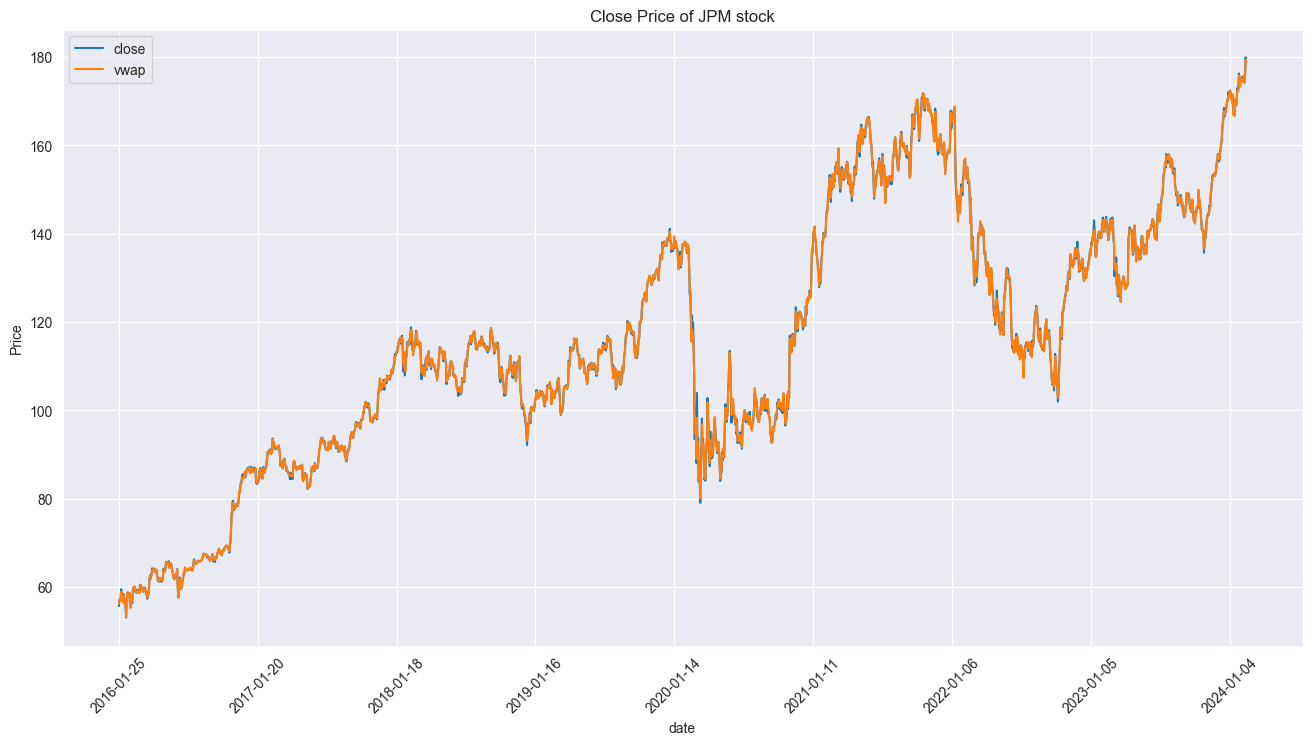

In [26]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['vwap'].plot(kind='line')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


##### The 'vwap' is a feature variable which is an independent, and 'close' price is the target, which is a dependent variable (explainable).  

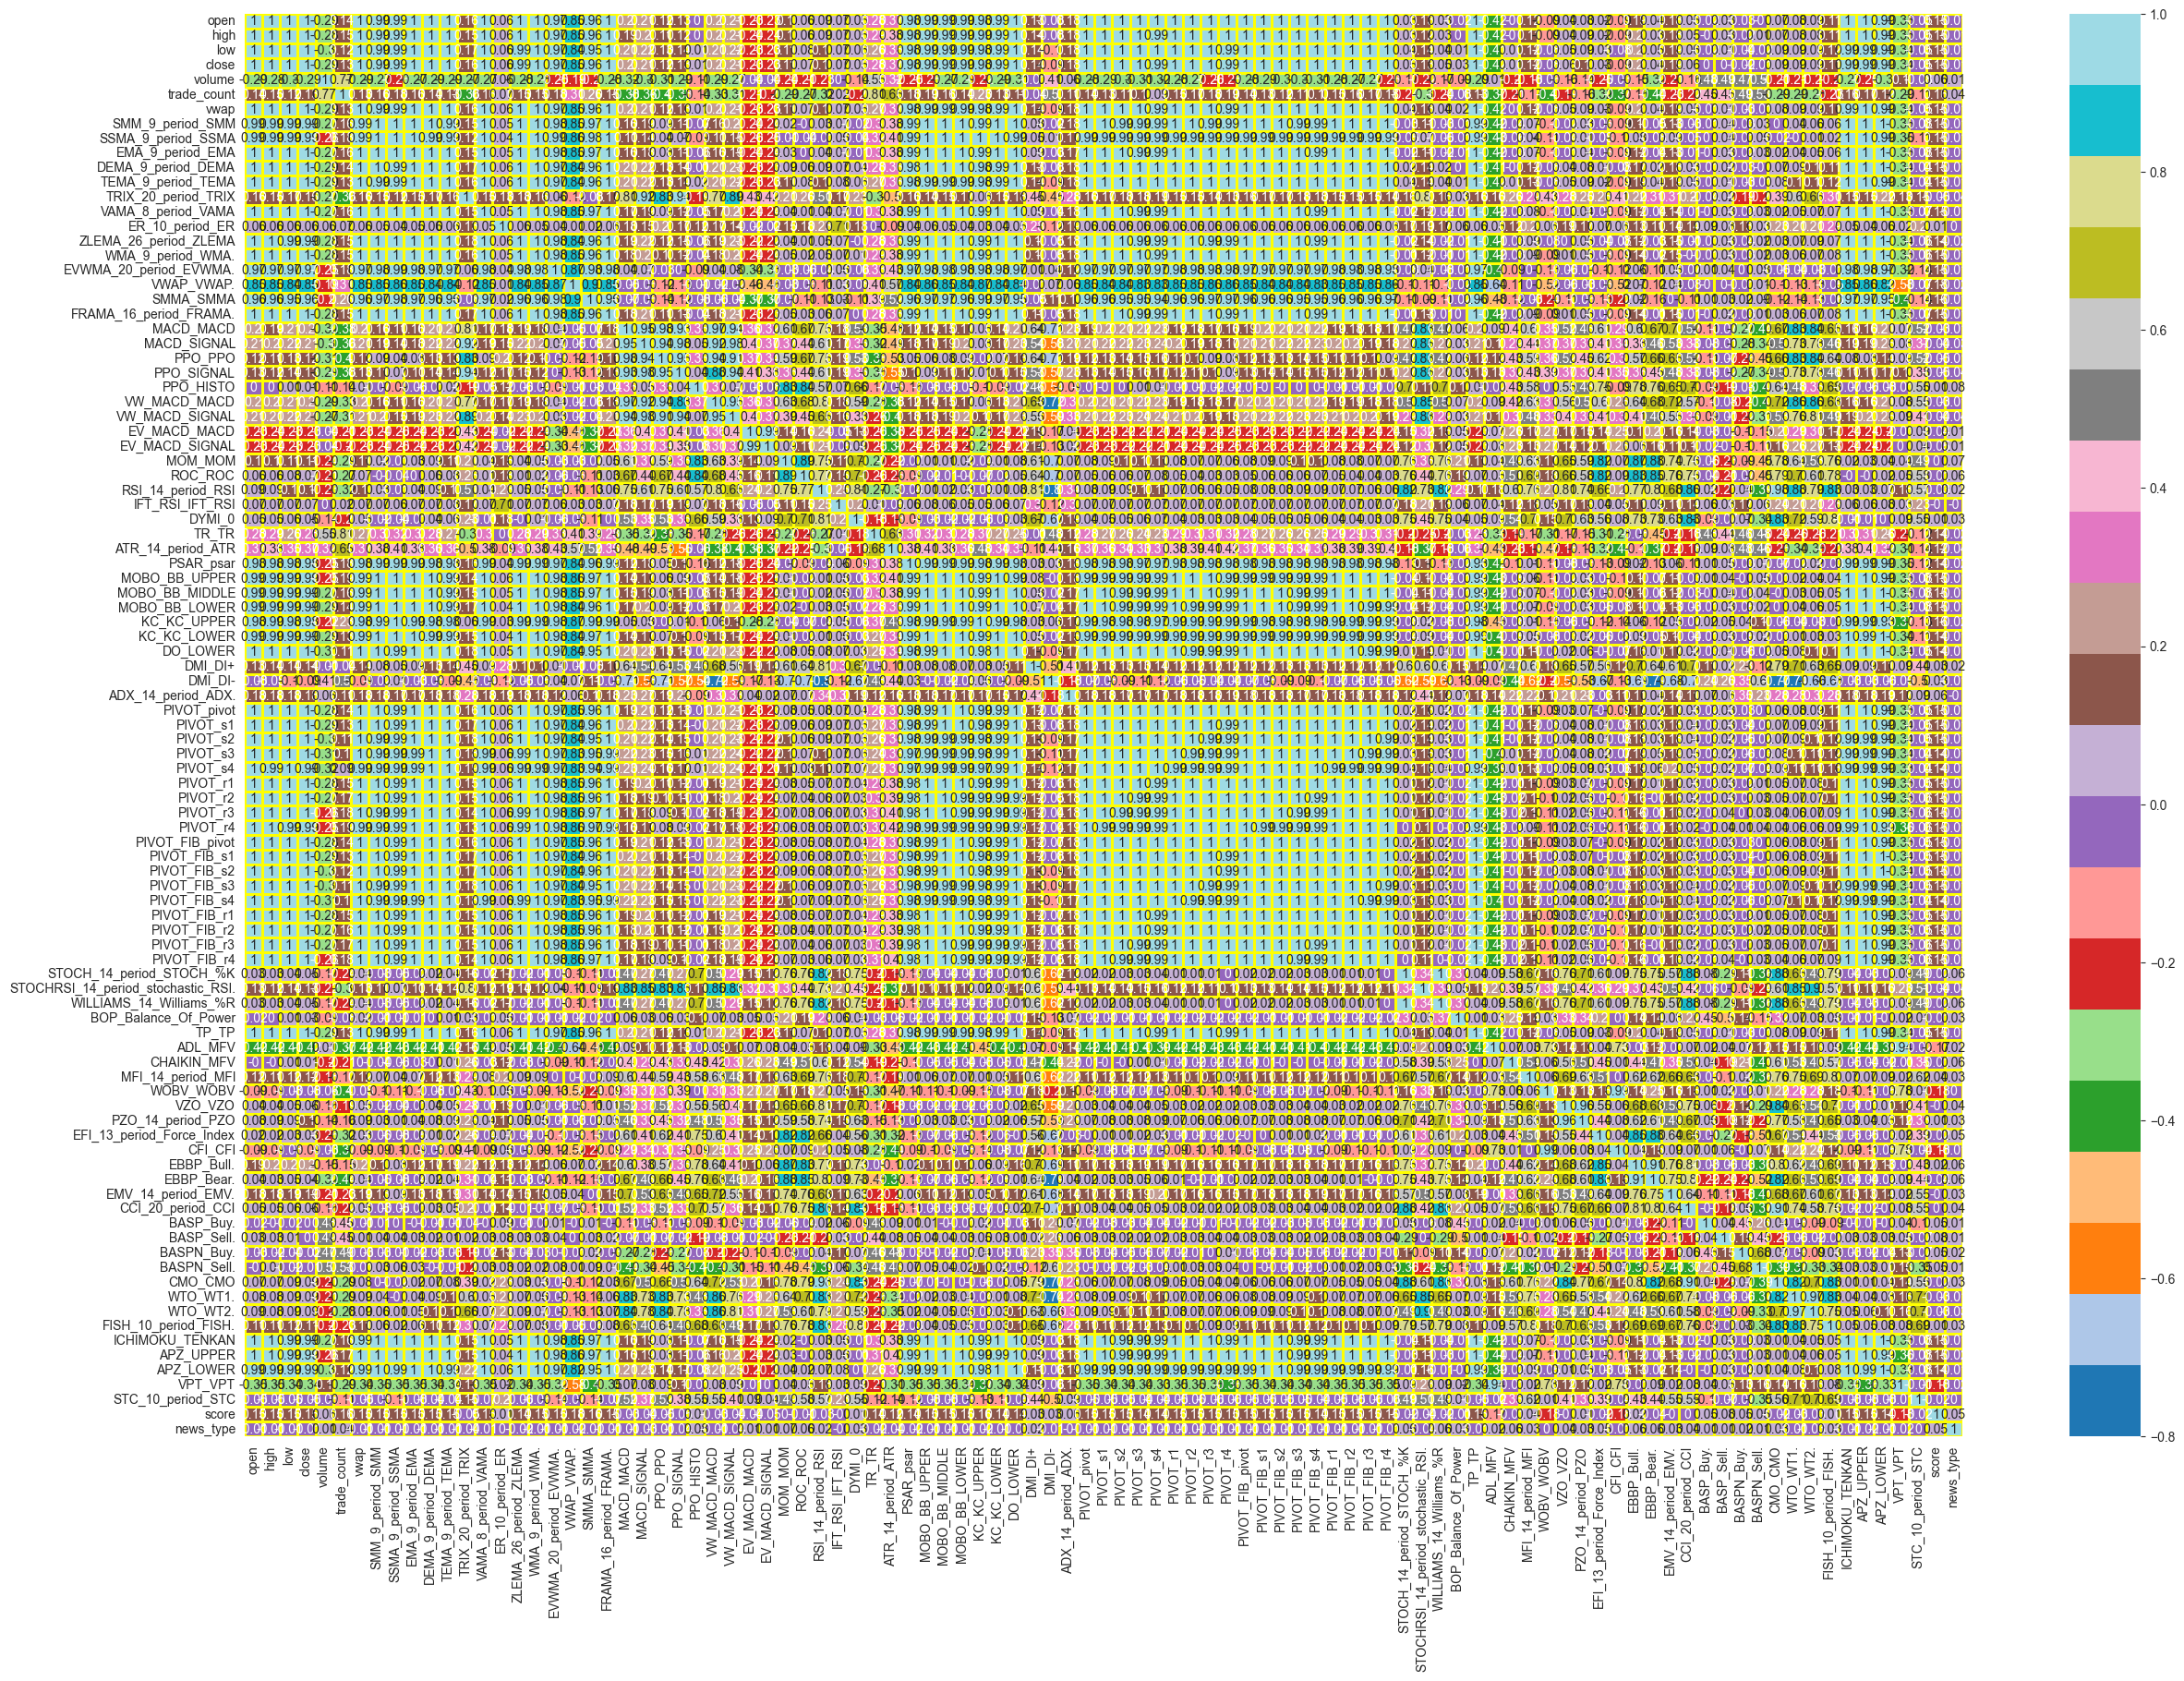

In [27]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [28]:
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

#### Removing highly correlated features, the 'close' price is the target feature

In [29]:
low_corr_columns = ['close', 'vwap', 'volume', 'trade_count', 'TRIX_20_period_TRIX', 'ER_10_period_ER', 'PPO_HISTO', 'VW_MACD_MACD', 'MOM_MOM', 'ROC_ROC', 'RSI_14_period_RSI', 'IFT_RSI_IFT_RSI', 'DYMI_0', 'TR_TR', 'BOP_Balance_Of_Power', 'ADL_MFV', 'VZO_VZO', 'EBBP_Bull.', 'EBBP_Bear.', 'BASP_Buy.', 'BASP_Sell.', 'BASPN_Buy.', 'BASPN_Sell.', 'VPT_VPT', 'score', 'news_type']

In [30]:
df_corr  = df[low_corr_columns]

<Axes: >

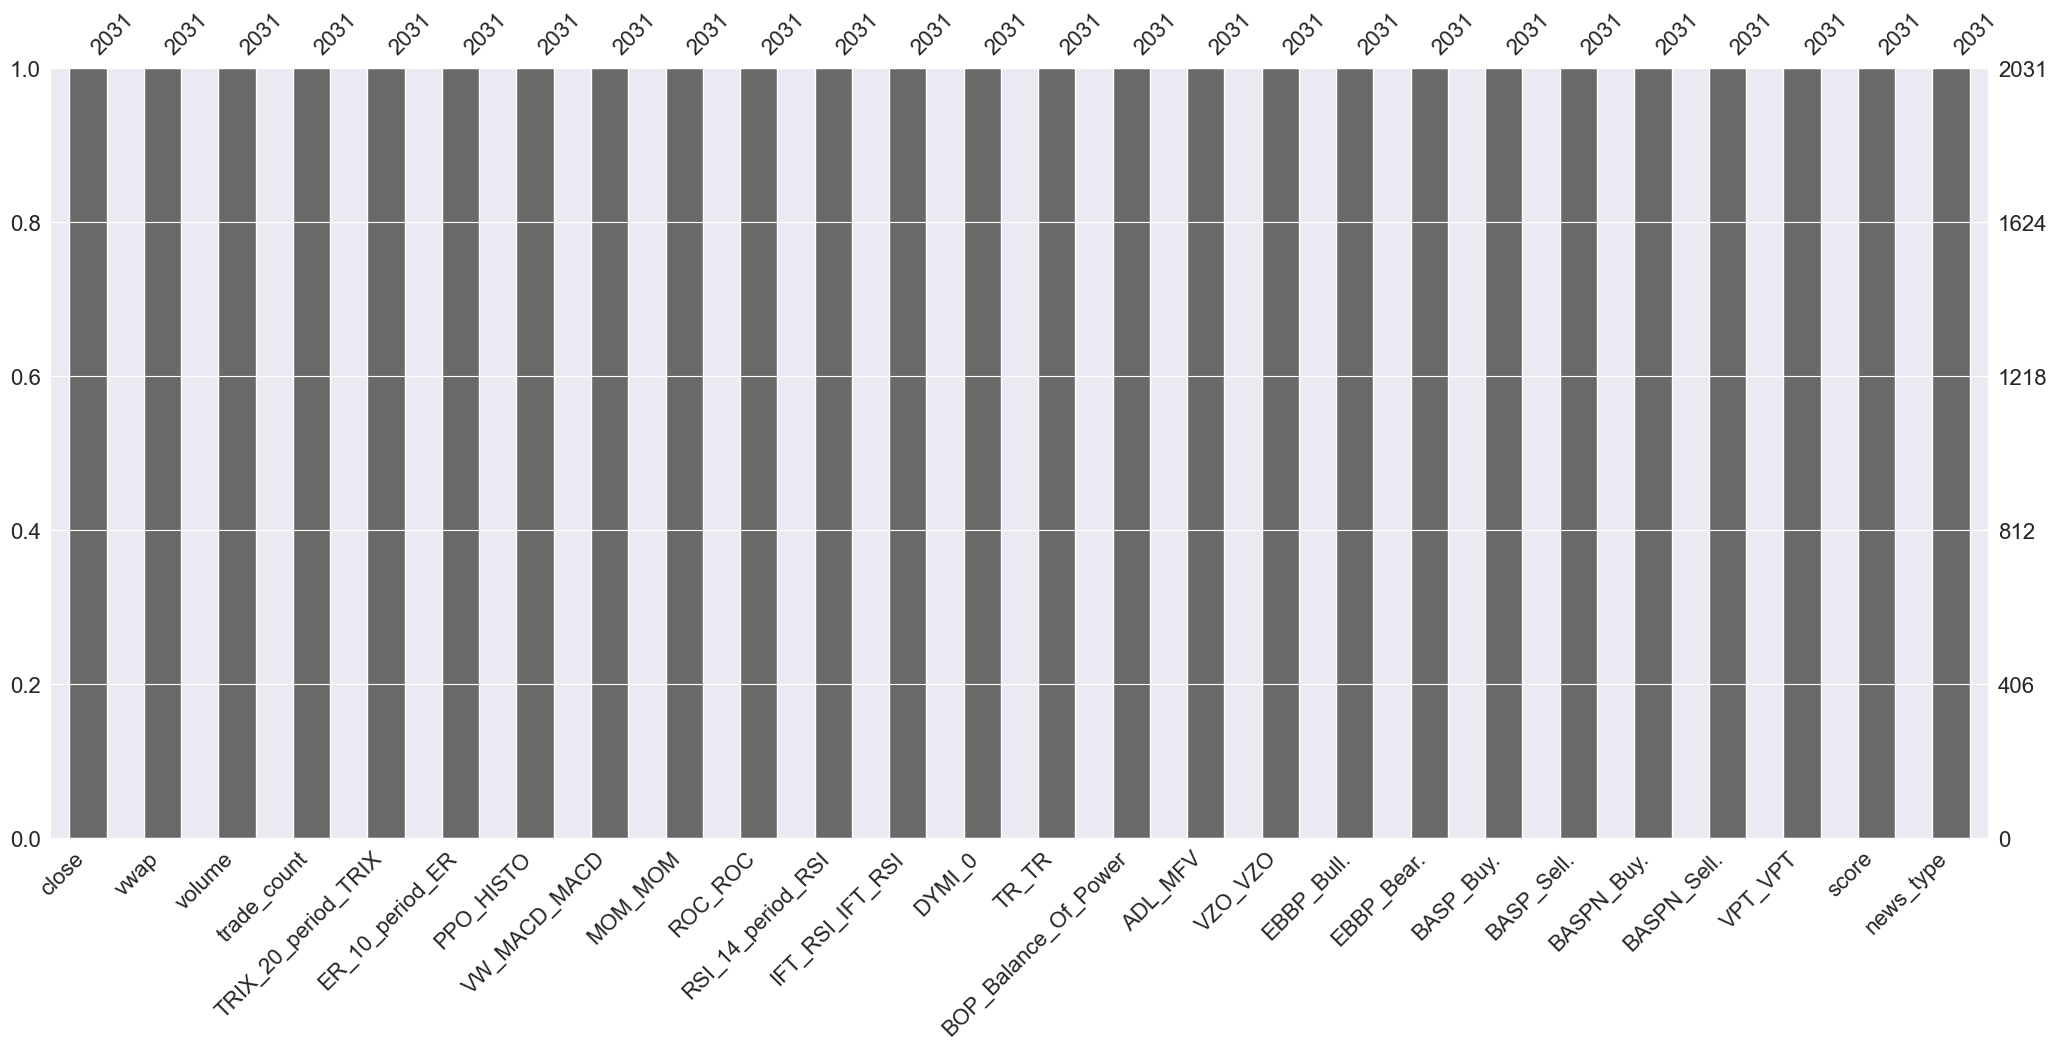

In [31]:
msno.bar(df_corr)

In [32]:
df_corr.head()

close       vwap      volume  trade_count  TRIX_20_period_TRIX  \
date                                                                         
2016-01-25  55.66  56.137613  22118832.0     139637.0            -0.361674   
2016-01-26  57.08  56.810083  19392731.0     107516.0            -0.357426   
2016-01-27  57.04  57.319320  21426316.0     141369.0            -0.349905   
2016-01-28  57.28  57.280159  16677125.0     109380.0            -0.339606   
2016-01-29  59.50  58.803356  32348693.0     140585.0            -0.322356   

            ER_10_period_ER  PPO_HISTO  VW_MACD_MACD  MOM_MOM    ROC_ROC  ...  \
date                                                                      ...   
2016-01-25         0.377315  -0.255183     -0.632199    -3.26 -11.383538  ...   
2016-01-26         0.175527  -0.108513     -0.583954    -1.75  -5.292849  ...   
2016-01-27         0.194332  -0.006718     -0.537072    -1.92  -3.190767  ...   
2016-01-28         0.007059   0.086908     -0.492193    -0.06  -2.634710  ...   
2016-01-29         0.131846   0.347635     -0.233621     1.30   0.915875  ...   

              VZO_VZO  EBBP_Bull.  EBBP_Bear.  BASP_Buy.  BASP_Sell.  \
date                                                                   
2016-01-25 -49.498185   -0.408985   -1.658985   0.087404    0.950238   
2016-01-26 -33.854795   -0.081043   -1.421043   1.486910    0.054953   
2016-01-27 -41.639946    1.068290   -0.641610   0.643949    1.053714   
2016-01-28 -28.099366    0.756447   -0.583553   0.694935    0.485192   
2016-01-29  -5.521798    1.981364   -0.048636   3.413158    0.057988   

            BASPN_Buy.  BASPN_Sell.       VPT_VPT     score  news_type  
date                                                                    
2016-01-25    1.008164     1.079303 -1.721438e+08  0.966308          1  
2016-01-26    1.065274     0.957108 -1.365423e+08  0.928192         -1  
2016-01-27    1.016194     0.968362 -1.380459e+08  0.000000          0  
2016-01-28    0.979550     0.913249 -1.440198e+08  0.999341          1  
2016-01-29    1.252009     0.817497 -9.175200e+07  0.000000          0  

[5 rows x 26 columns]

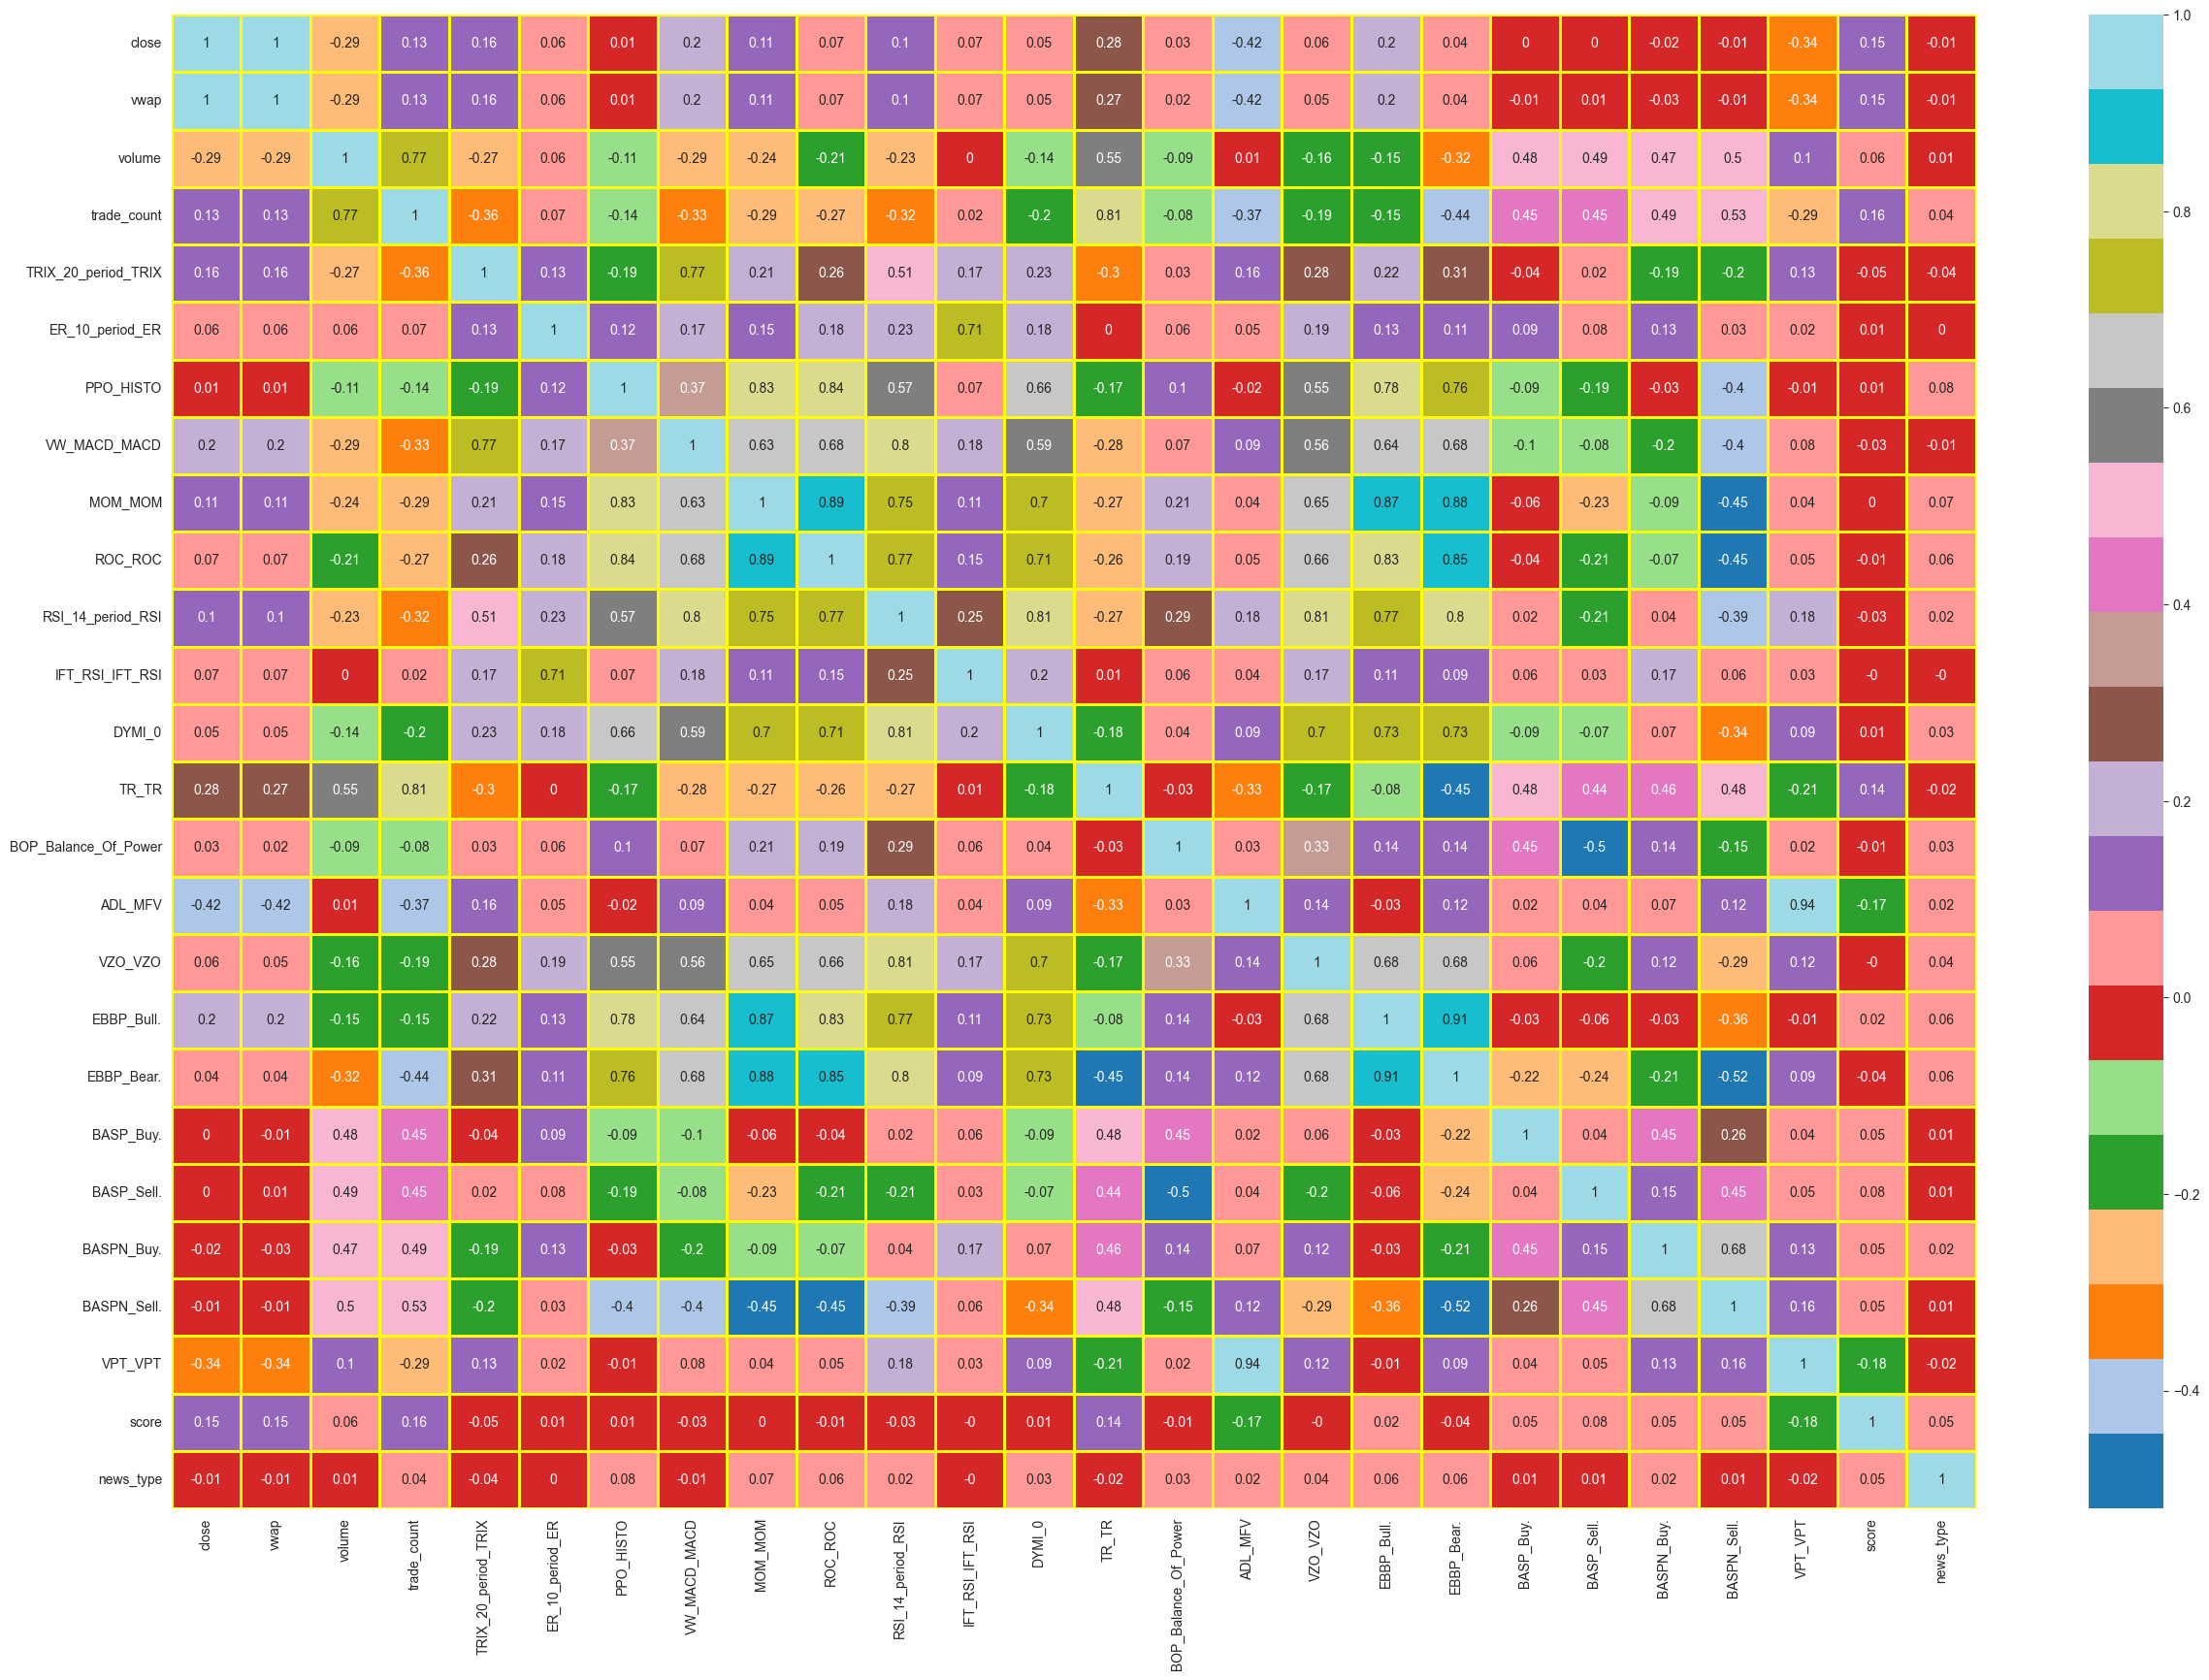

In [33]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [34]:
# Correlations to the Target feature 'close'
corr_matrix = pd.DataFrame(corr_low)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

In [35]:
df_corr.describe()

close         vwap        volume    trade_count  \
count  2031.000000  2031.000000  2.031000e+03    2031.000000   
mean    115.860202   115.856386  1.551844e+07  113788.557361   
std      29.139963    29.135868  7.335347e+06   53221.828203   
min      53.070000    53.284123  1.604000e+05       1.000000   
25%      96.835000    96.797377  1.077753e+07   79403.000000   
50%     113.730000   113.762876  1.400482e+07  101395.000000   
75%     138.595000   138.593747  1.785494e+07  130767.500000   
max     179.870000   179.302307  7.290765e+07  457367.000000   

       TRIX_20_period_TRIX  ER_10_period_ER    PPO_HISTO  VW_MACD_MACD  \
count          2031.000000      2031.000000  2031.000000   2031.000000   
mean              0.049258         0.340774     0.004401      0.528302   
std               0.216050         0.232480     0.558555      1.897987   
min              -1.037542         0.000000    -3.149239     -7.296078   
25%              -0.069289         0.146181    -0.295337     -0.570920   
50%               0.068188         0.307463    -0.004567      0.589033   
75%               0.170014         0.505496     0.295890      1.655692   
max               0.531040         1.000000     2.693997      5.740988   

           MOM_MOM      ROC_ROC  ...      VZO_VZO   EBBP_Bull.   EBBP_Bear.  \
count  2031.000000  2031.000000  ...  2031.000000  2031.000000  2031.000000   
mean      0.583855     0.821235  ...     0.628973     1.427755    -0.754054   
std       6.116561     5.678879  ...    28.169637     2.912634     3.265767   
min     -38.720000   -32.038694  ...   -74.469169   -18.529212   -24.759412   
25%      -2.220000    -2.179047  ...   -19.204509    -0.021691    -2.079163   
50%       0.800000     0.983441  ...     0.084250     1.320374    -0.337884   
75%       3.910000     3.897815  ...    21.109410     2.886919     1.081735   
max      23.980000    25.442653  ...    83.096700    15.997130    10.213254   

         BASP_Buy.   BASP_Sell.   BASPN_Buy.  BASPN_Sell.       VPT_VPT  \
count  2031.000000  2031.000000  2031.000000  2031.000000  2.031000e+03   
mean      1.050935     1.066919     1.051337     1.067519  2.499586e+08   
std       1.168901     1.256427     0.354404     0.388103  3.670175e+08   
min       0.000000     0.000000     0.495873     0.435377 -3.914145e+08   
25%       0.384351     0.337504     0.845338     0.829395 -6.690271e+07   
50%       0.739943     0.702929     0.980772     0.979598  1.715603e+08   
75%       1.342029     1.331497     1.157925     1.207113  6.153091e+08   
max      12.257612    13.974026     3.520925     3.671142  9.704963e+08   

             score    news_type  
count  2031.000000  2031.000000  
mean      0.639649     0.099951  
std       0.439303     0.824116  
min       0.000000    -1.000000  
25%       0.000000    -1.000000  
50%       0.925717     0.000000  
75%       0.987948     1.000000  
max       0.999861     1.000000  

[8 rows x 26 columns]

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'VW_MACD_MACD'}>,
        <Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'DYMI_0'}>,
        <Axes: title={'center': 'TR_TR'}>,
        <Axes: title={'center': 'BOP_Balance_Of_Power'}>],
       [<Axes: title={'center': 'ADL_MFV'}>,
        <Axes: title={'center': 'VZO_VZO'}>,
        <Axes: title={'center': 'EBBP_Bull.'}>,
        <Axes: title={'center': 'EBBP_Bear.'}>,
        <Axes: title={'center': 'BASP_Buy.'}>],
       [<Axes: title={'center': 'BA

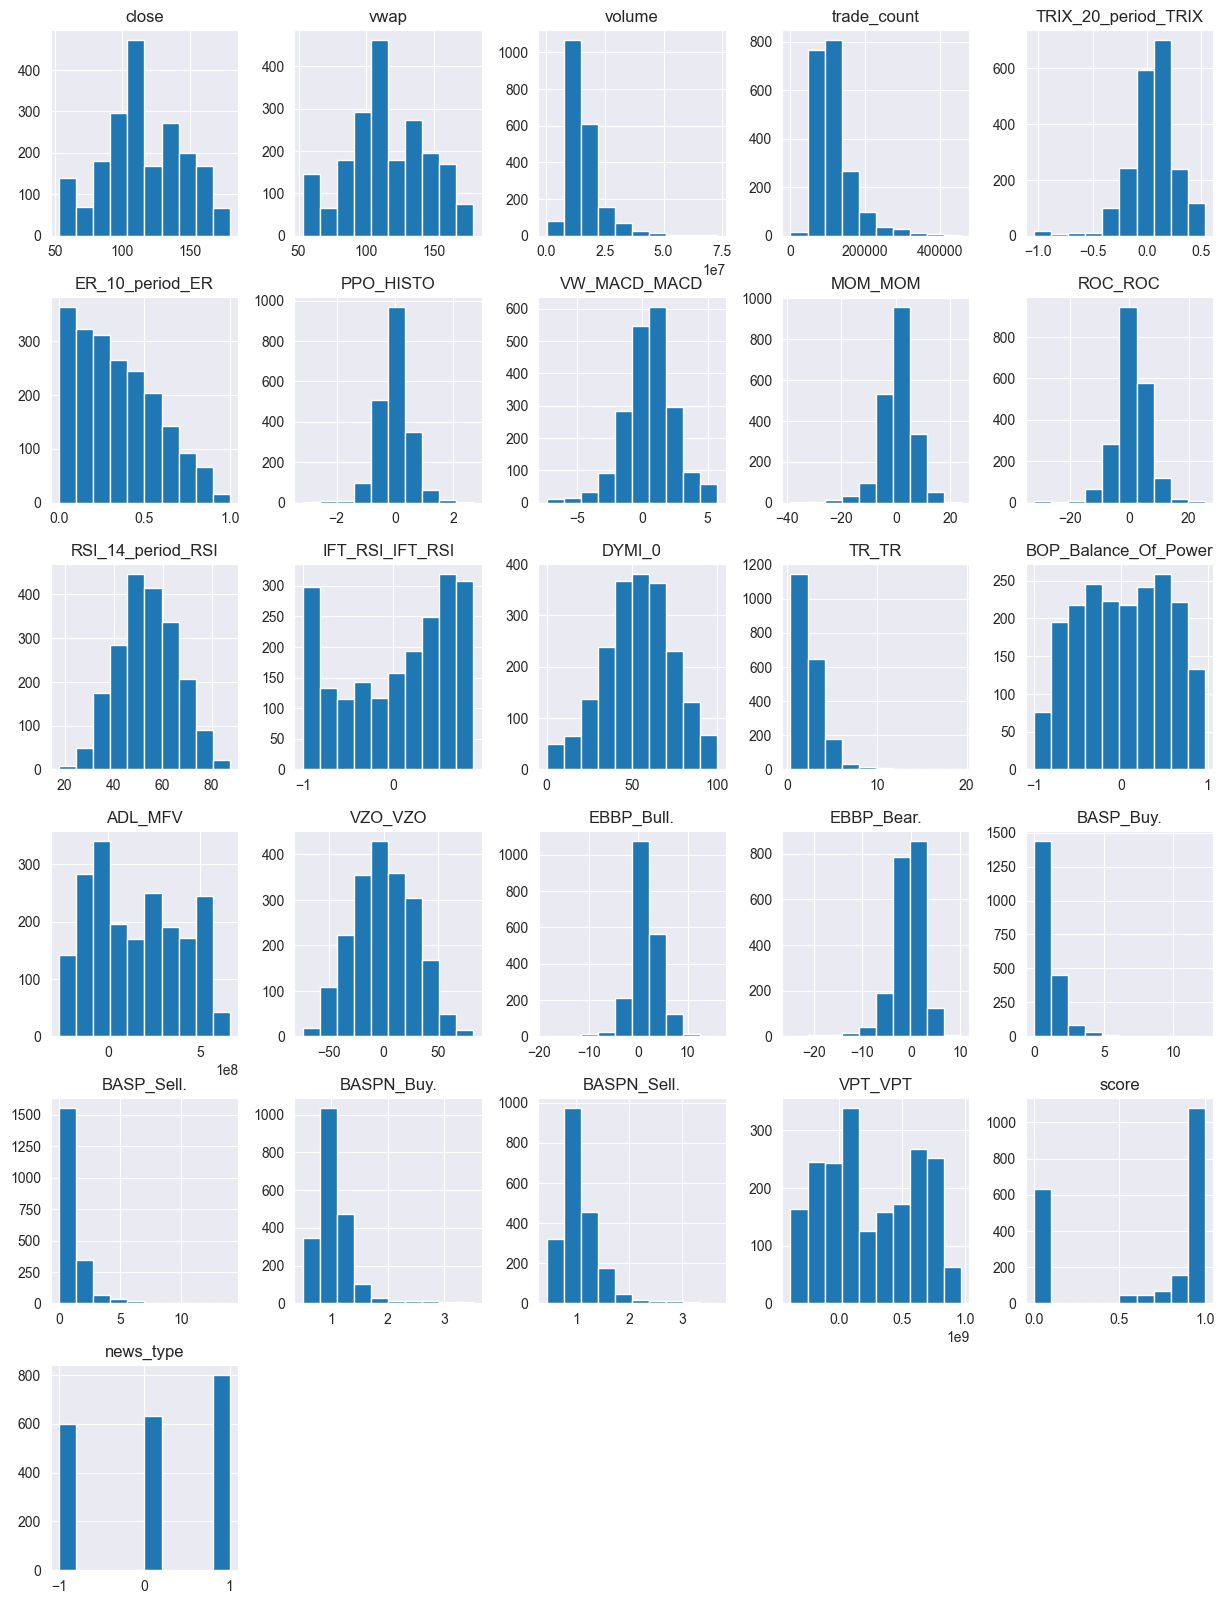

In [36]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

##### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right
##### even the 'vwap' feature is highly correlated to the target, it is kept. The "Volume Weighted Average Price" is a benchmark indicator for traders

In [37]:
#Scaling dataset before Normalising it
data = df_corr.copy()
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_corr)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_columns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_columns, named_columns))]
columns = dict(tuples)
df_norm.rename(columns=columns, inplace=True)
df_norm = df_norm[named_columns]
df_norm.index = df.index
df_norm.describe()

close         vwap       volume  trade_count  \
count  2031.000000  2031.000000  2031.000000  2031.000000   
mean      0.000241     0.000317    -0.000092    -0.000494   
std       1.009778     1.010305     1.009248     1.011077   
min      -5.199338    -5.199338    -5.199338    -5.199338   
25%      -0.673872    -0.673884    -0.673853    -0.674339   
50%       0.000418     0.000838    -0.000224     0.000769   
75%       0.674244     0.674959     0.674586     0.674229   
max       5.199338     5.199338     5.199338     5.199338   

       TRIX_20_period_TRIX  ER_10_period_ER    PPO_HISTO  VW_MACD_MACD  \
count          2031.000000      2031.000000  2031.000000   2031.000000   
mean             -0.000175        -0.000173    -0.000066      0.000223   
std               1.009742         1.009719     1.009556      1.009856   
min              -5.199338        -5.199338    -5.199338     -5.199338   
25%              -0.674892        -0.674758    -0.674430     -0.673908   
50%               0.001207        -0.000250    -0.000870     -0.000364   
75%               0.673731         0.674551     0.674264      0.674313   
max               5.199338         5.199338     5.199338      5.199338   

           MOM_MOM      ROC_ROC  ...      VZO_VZO   EBBP_Bull.   EBBP_Bear.  \
count  2031.000000  2031.000000  ...  2031.000000  2031.000000  2031.000000   
mean     -0.000104     0.000100  ...    -0.000028     0.000194     0.000005   
std       1.009584     1.009581  ...     1.010617     1.010266     1.009243   
min      -5.199338    -5.199338  ...    -5.199338    -5.199338    -5.199338   
25%      -0.675277    -0.675150  ...    -0.674472    -0.675168    -0.674840   
50%      -0.001255     0.000385  ...    -0.000133    -0.000666     0.001139   
75%       0.674336     0.674665  ...     0.674531     0.674536     0.674713   
max       5.199338     5.199338  ...     5.199338     5.199338     5.199338   

         BASP_Buy.   BASP_Sell.   BASPN_Buy.   BASPN_Sell.      VPT_VPT  \
count  2031.000000  2031.000000  2031.000000  2.031000e+03  2031.000000   
mean     -0.014211    -0.014187     0.000058 -1.472508e-07     0.000014   
std       1.064485     1.064568     1.009655  1.008970e+00     1.009318   
min      -5.199338    -5.199338    -5.199338 -5.199338e+00    -5.199338   
25%      -0.674813    -0.675185    -0.675017 -6.739928e-01    -0.674754   
50%       0.000866     0.000783     0.000339 -8.476617e-04    -0.000152   
75%       0.674248     0.674085     0.673873  6.748062e-01     0.674662   
max       5.199338     5.199338     5.199338  5.199338e+00     5.199338   

             score    news_type  
count  2031.000000  2031.000000  
mean     -1.263013     0.480536  
std       2.710281     4.290001  
min      -5.199338    -5.199338  
25%      -5.199338    -5.199338  
50%       0.000302    -0.125788  
75%       0.674719     5.199338  
max       5.199338     5.199338  

[8 rows x 26 columns]

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'VW_MACD_MACD'}>,
        <Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'DYMI_0'}>,
        <Axes: title={'center': 'TR_TR'}>,
        <Axes: title={'center': 'BOP_Balance_Of_Power'}>],
       [<Axes: title={'center': 'ADL_MFV'}>,
        <Axes: title={'center': 'VZO_VZO'}>,
        <Axes: title={'center': 'EBBP_Bull.'}>,
        <Axes: title={'center': 'EBBP_Bear.'}>,
        <Axes: title={'center': 'BASP_Buy.'}>],
       [<Axes: title={'center': 'BA

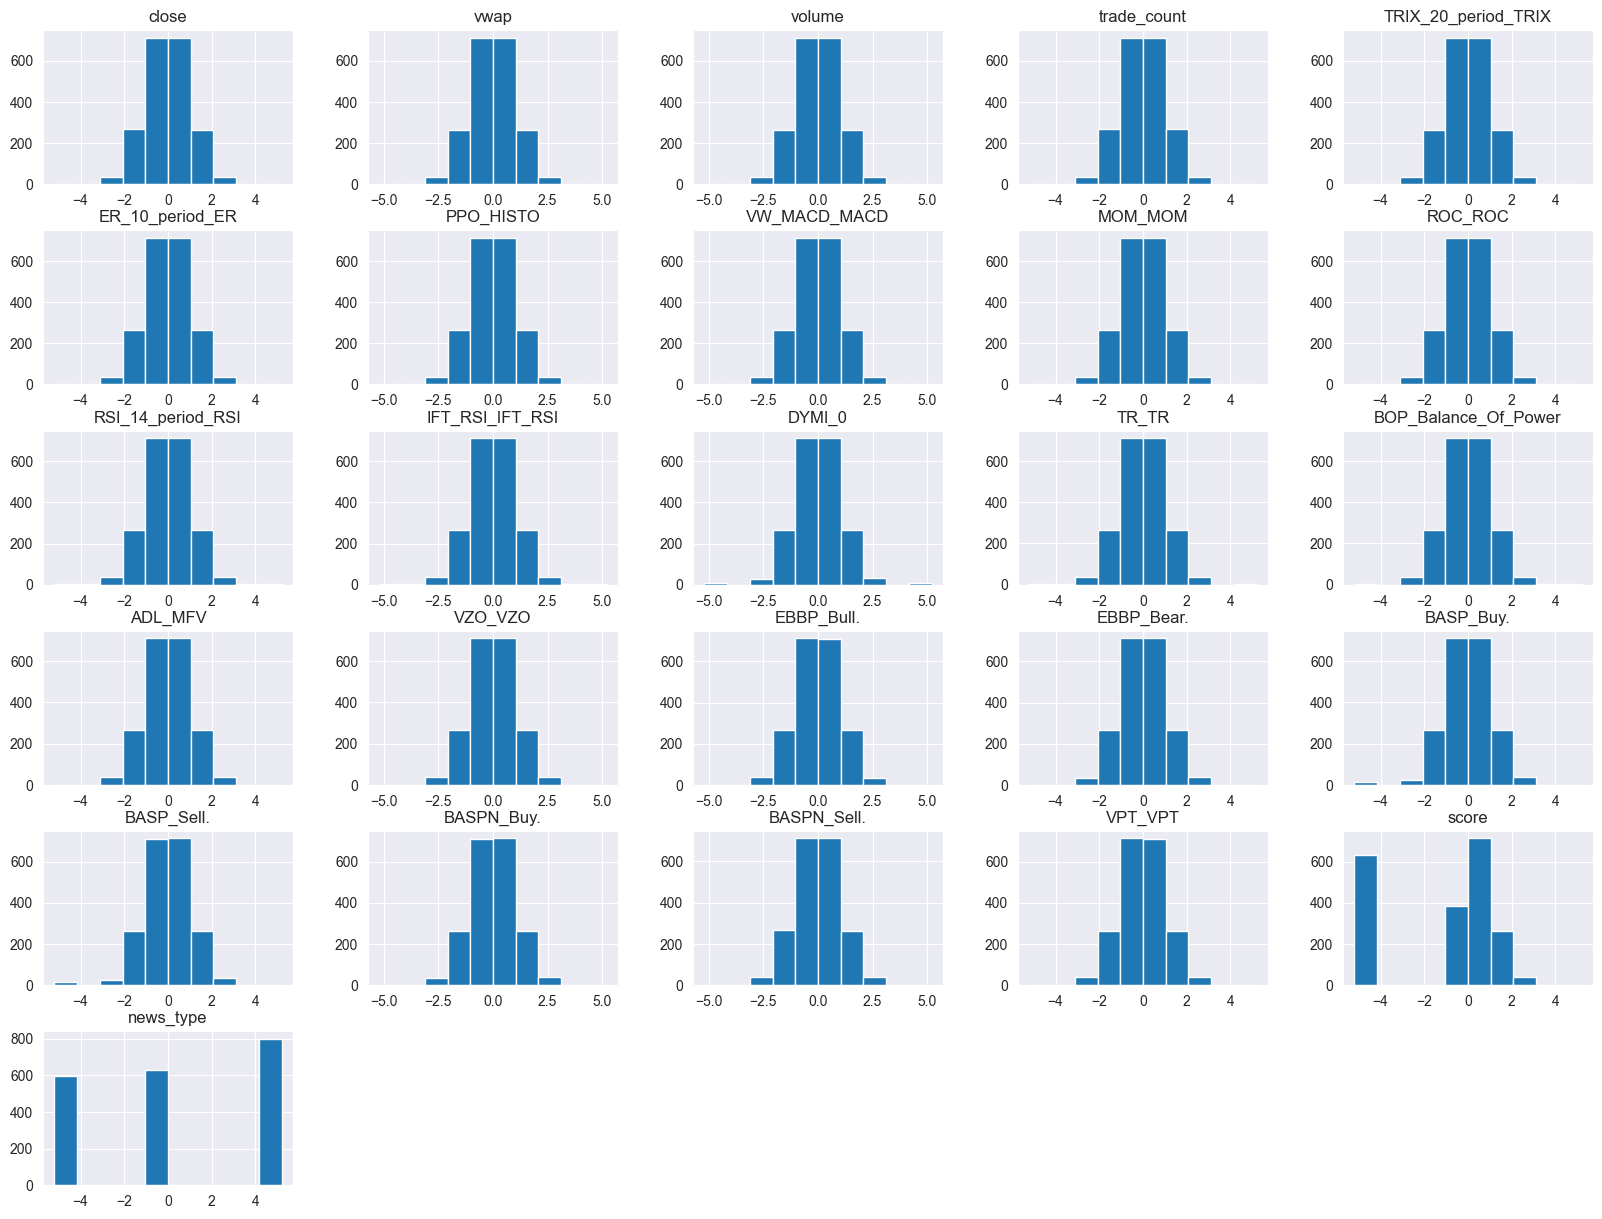

In [38]:
df_norm.hist(figsize=(20,15))

##### As we can see from the describe method of pandas DataFrame, the mean is 0 and std is 1 and from the above bell shape plots, now our dataset has a normal distribution

In [39]:
df_norm.head()

close      vwap    volume  trade_count  TRIX_20_period_TRIX  \
date                                                                         
2016-01-25 -3.091620 -2.904183  1.121436     0.829565            -1.944562   
2016-01-26 -2.565971 -2.567976  0.862773     0.138892            -1.901155   
2016-01-27 -2.588802 -2.472947  1.067647     0.875014            -1.865830   
2016-01-28 -2.513670 -2.482284  0.504749     0.201002            -1.815849   
2016-01-29 -2.011333 -2.149918  1.742471     0.862872            -1.757197   

            ER_10_period_ER  PPO_HISTO  VW_MACD_MACD   MOM_MOM   ROC_ROC  ...  \
date                                                                      ...   
2016-01-25         0.238186  -0.591767     -0.708743 -0.877196 -1.959964  ...   
2016-01-26        -0.534035  -0.221918     -0.683649 -0.564267 -1.270401  ...   
2016-01-27        -0.437513  -0.006245     -0.651909 -0.602199 -0.891998  ...   
2016-01-28        -2.296964   0.185072     -0.626562 -0.177827 -0.772611  ...   
2016-01-29        -0.764188   0.781473     -0.497776  0.127052 -0.009718  ...   

             VZO_VZO  EBBP_Bull.  EBBP_Bear.  BASP_Buy.  BASP_Sell.  \
date                                                                  
2016-01-25 -1.825017   -0.814610   -0.511392  -1.647104    0.319573   
2016-01-26 -1.198812   -0.700322   -0.430248   0.806724   -1.774854   
2016-01-27 -1.482299   -0.101715   -0.117842  -0.153342    0.419641   
2016-01-28 -0.969565   -0.279977   -0.091644  -0.071710   -0.364653   
2016-01-29 -0.182663    0.307386    0.135013   1.821444   -1.733590   

            BASPN_Buy.  BASPN_Sell.   VPT_VPT     score  news_type  
date                                                                
2016-01-25    0.125967     0.341097 -1.002251  0.275872   5.199338  
2016-01-26    0.338244    -0.093191 -0.908303  0.006835  -5.199338  
2016-01-27    0.158432    -0.048999 -0.912927 -5.199338  -0.125788  
2016-01-28   -0.003735    -0.291524 -0.930069  1.915579   5.199338  
2016-01-29    0.948979    -0.724583 -0.747861 -5.199338  -0.125788  

[5 rows x 26 columns]

### Modeling

In [40]:
X = df.drop(columns=['close'], axis=1)
y = df_norm['close']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_corr = df_corr.drop(columns=['close'], axis=1)
y_corr = df_corr['close']
X_corr_train, X_corr_val, y_corr_train, y_corr_val = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)

X_norm = df_norm.drop(columns=['close'], axis=1)
y_norm = df_norm['close']
X_norm_train, X_norm_val, y_norm_train, y_norm_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [41]:
X_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
X_corr_val.sort_index(inplace=True)
X_corr_train.sort_index(inplace=True)
X_norm_val.sort_index(inplace=True)
X_norm_train.sort_index(inplace=True)

In [42]:
y_val.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_corr_val.sort_index(inplace=True)
y_corr_train.sort_index(inplace=True)
y_norm_val.sort_index(inplace=True)
y_norm_train.sort_index(inplace=True)

### Regression  Baseline Model using normalized data

In [43]:
complexity = 5
complex_index_norm = get_complexity(X_norm_train, X_norm_val, y_norm_train, y_norm_val, complexity)
poly_ordinal_norm = make_column_transformer((PolynomialFeatures(include_bias=False, degree=complex_index_norm), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  1 out of 5
The smallest mean squared error on the test dataset is :  0.0008 out of [0.0008, 0.001, 0.0085, 0.0305, 0.0018]
The best value of the R-sq of the model, as a good fit is:  0.9992 out of [0.9992, 0.999, 0.9911, 0.9681, 0.9981]


In [44]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge = Pipeline([('transformer', poly_ordinal_norm), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge.fit(X_norm_train, y_norm_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A4F4A7190>)])),
                ('scaler', StandardScaler()),
                ('ridgereg', RidgeCV(alphas=[0.001, 0.1, 1.0, 10.0, 100.0]))])

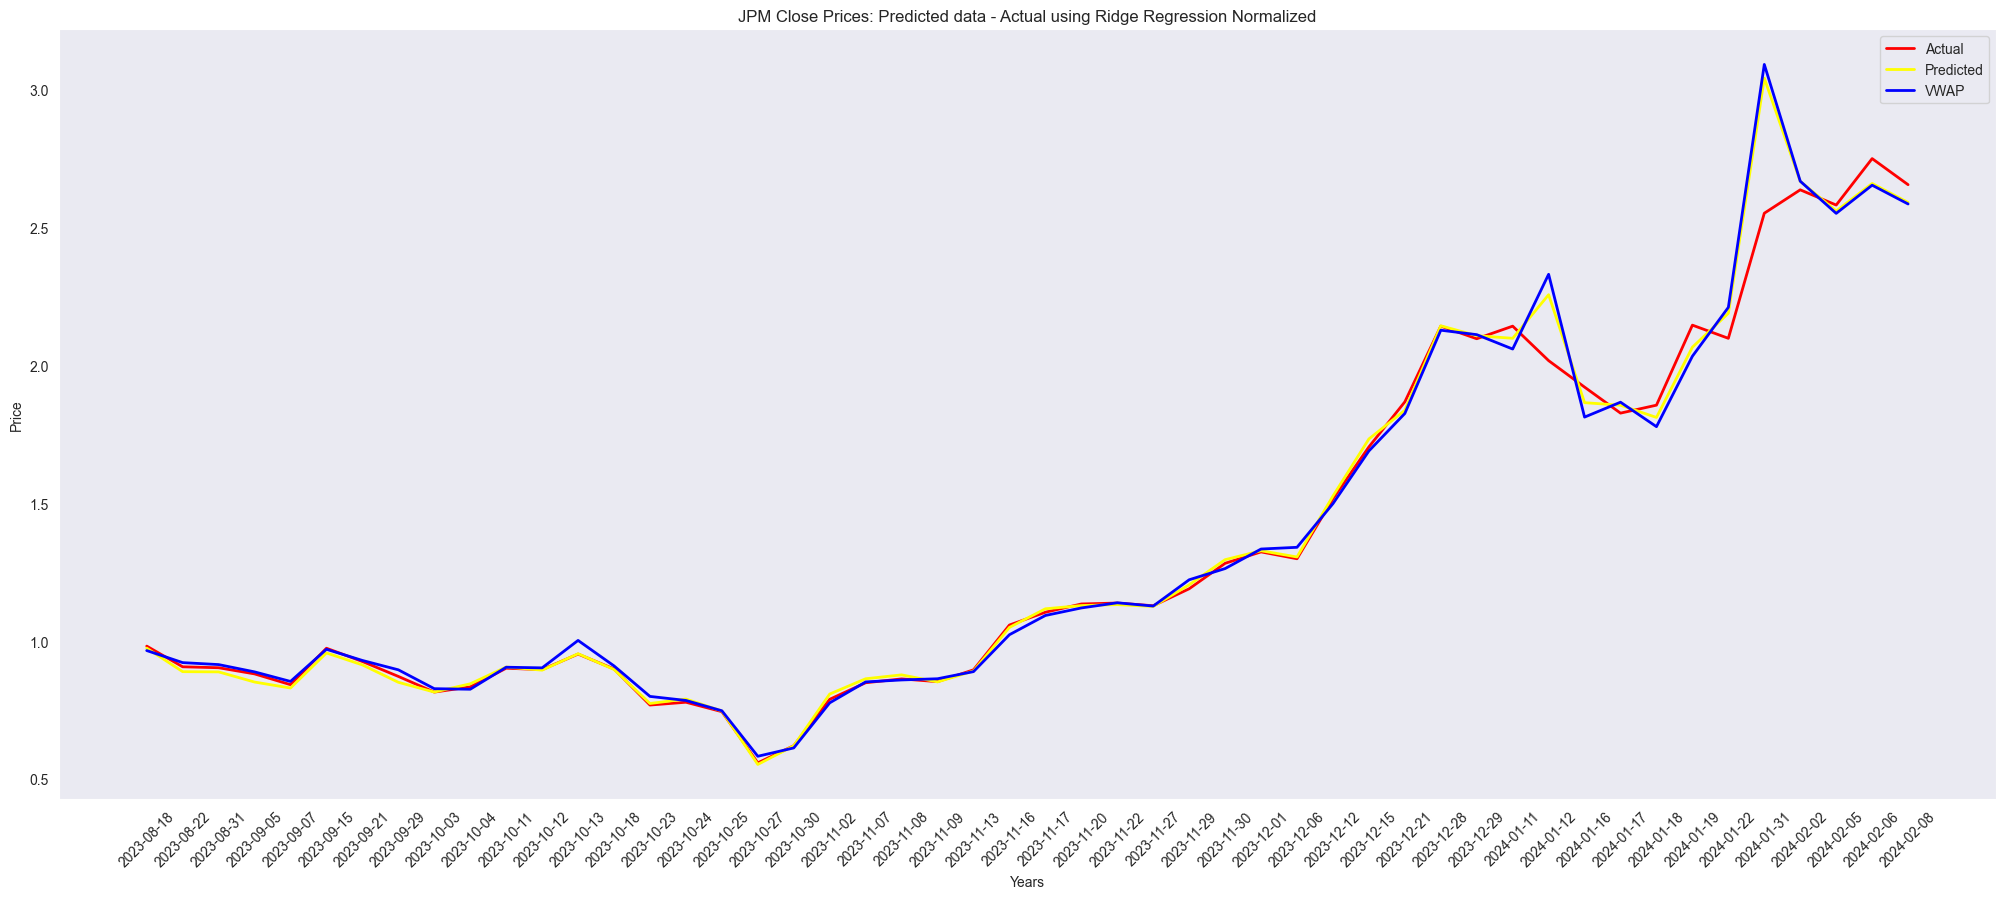

In [45]:
regression_model = {'Ridge Regression Normalized': ridge }
reg_model_metrics(regression_model, X_norm_train, X_norm_val, y_norm_train, y_norm_val)

### Regression Models

In [46]:
poly_degree = get_complexity(X_corr_train, X_corr_val, y_corr_train, y_corr_val, complexity)
poly_ordinal = make_column_transformer((PolynomialFeatures(include_bias=False, degree=poly_degree), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  1 out of 5
The smallest mean squared error on the test dataset is :  0.0877 out of [0.0877, 1662.9203, 431.1425, 1942.4335, 3379.9633]
The best value of the R-sq of the model, as a good fit is:  0.9999 out of [0.9999, -1.0236, 0.4753, -1.3637, -3.1131]


In [47]:
linreg = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_corr_train, y_corr_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_corr_train, y_corr_train)

lasso = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('lasso_reg', Lasso(alpha=0.01, random_state=42))])
lasso.fit(X_corr_train, y_corr_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal), ('scaler', MinMaxScaler()), ('clf', HuberRegressor(max_iter=1000))])
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_corr_train, y_corr_train)

rfr = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(random_state=0))])
rfr.fit(X_corr_train, y_corr_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A4A2C4610>)])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(random_state=0))])

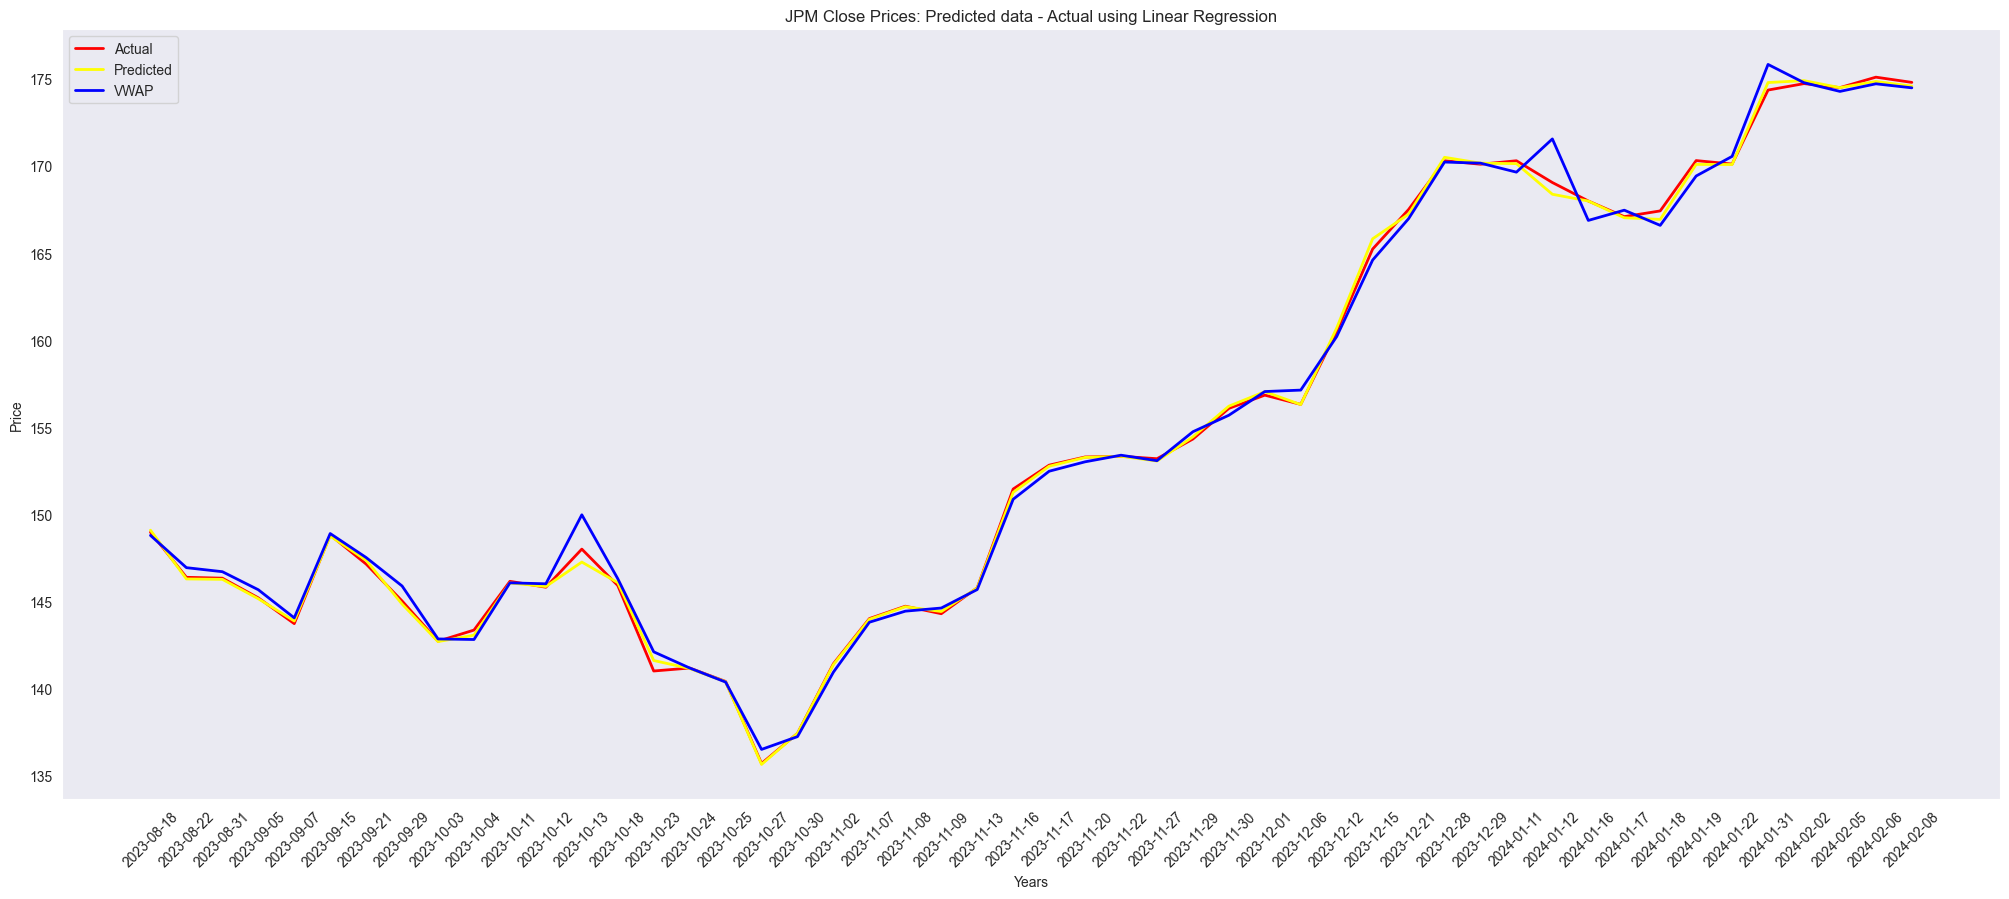

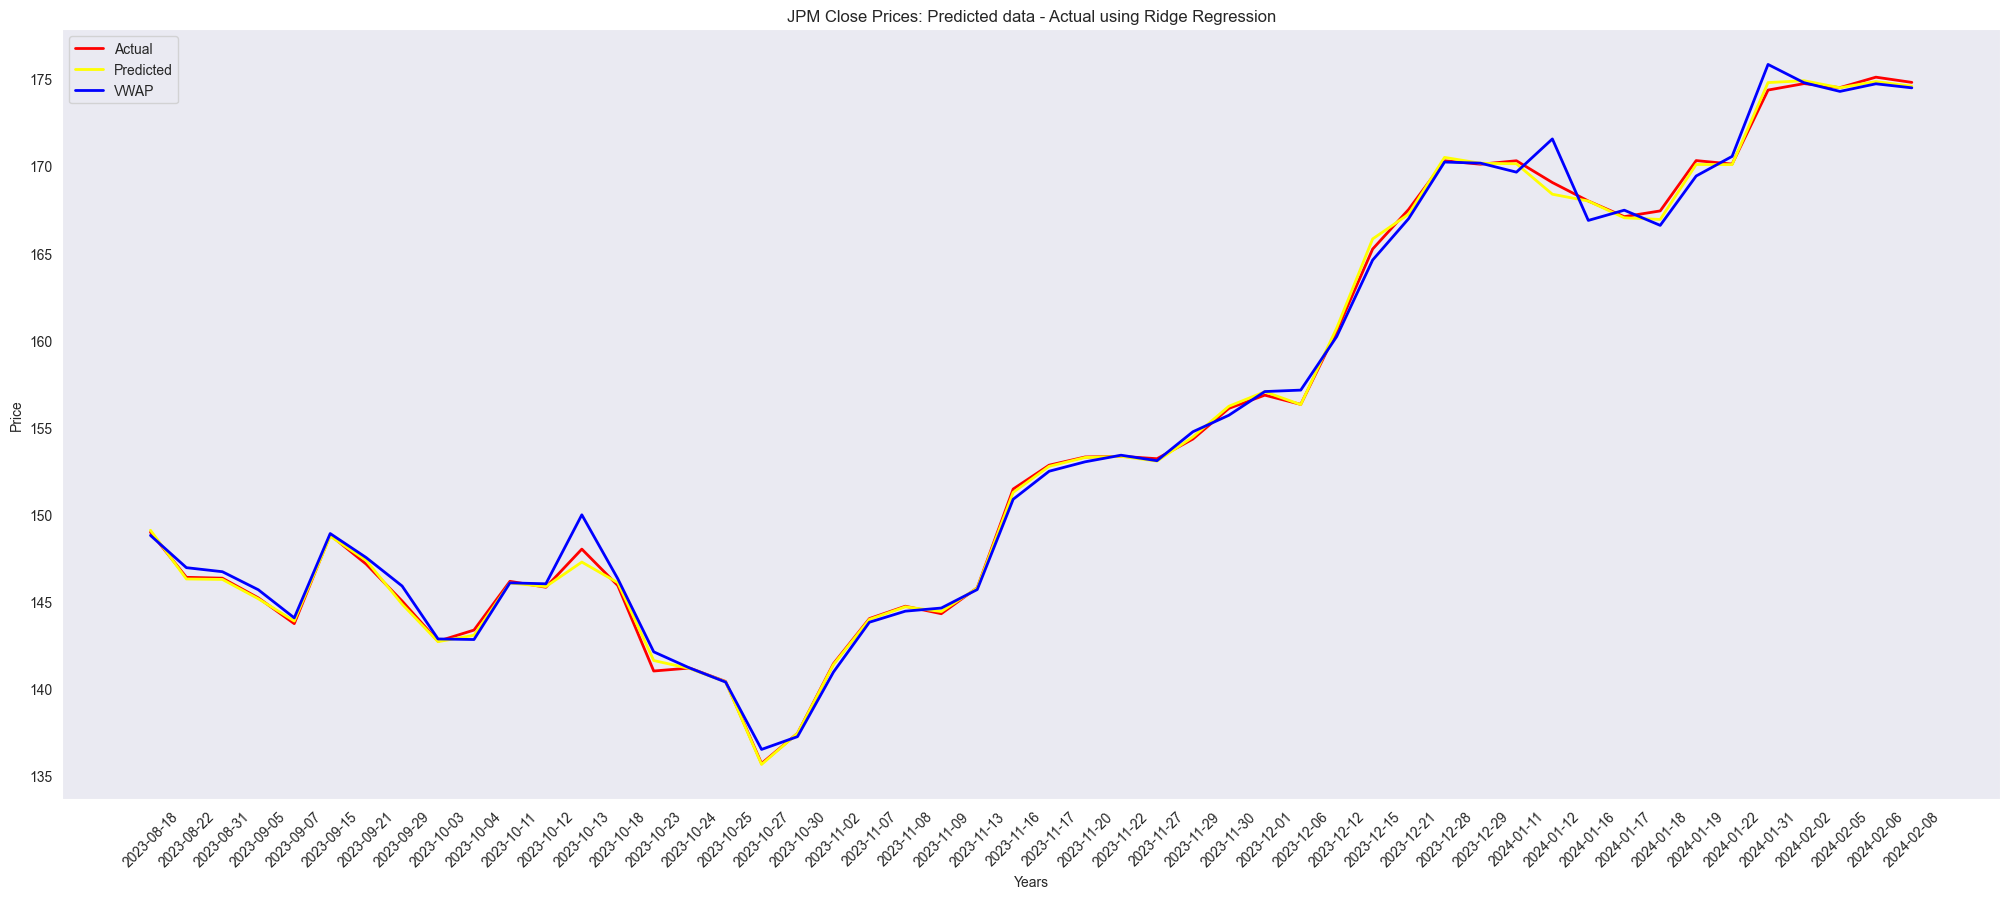

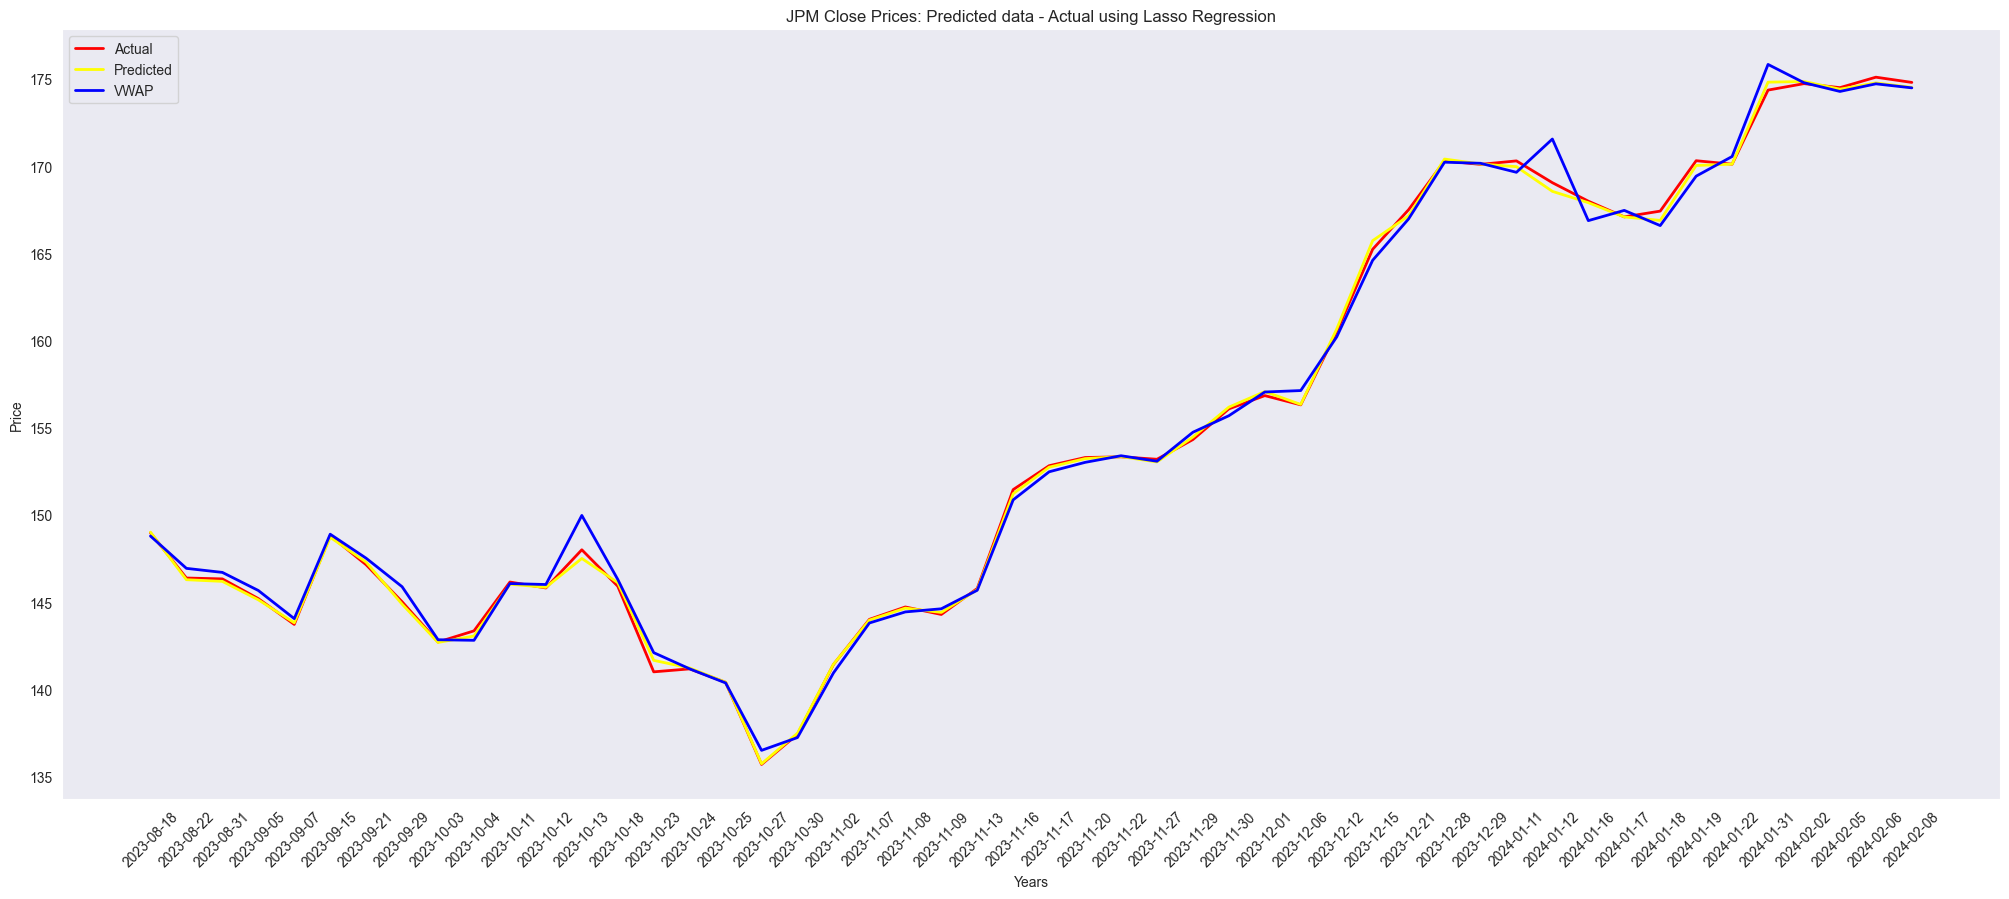

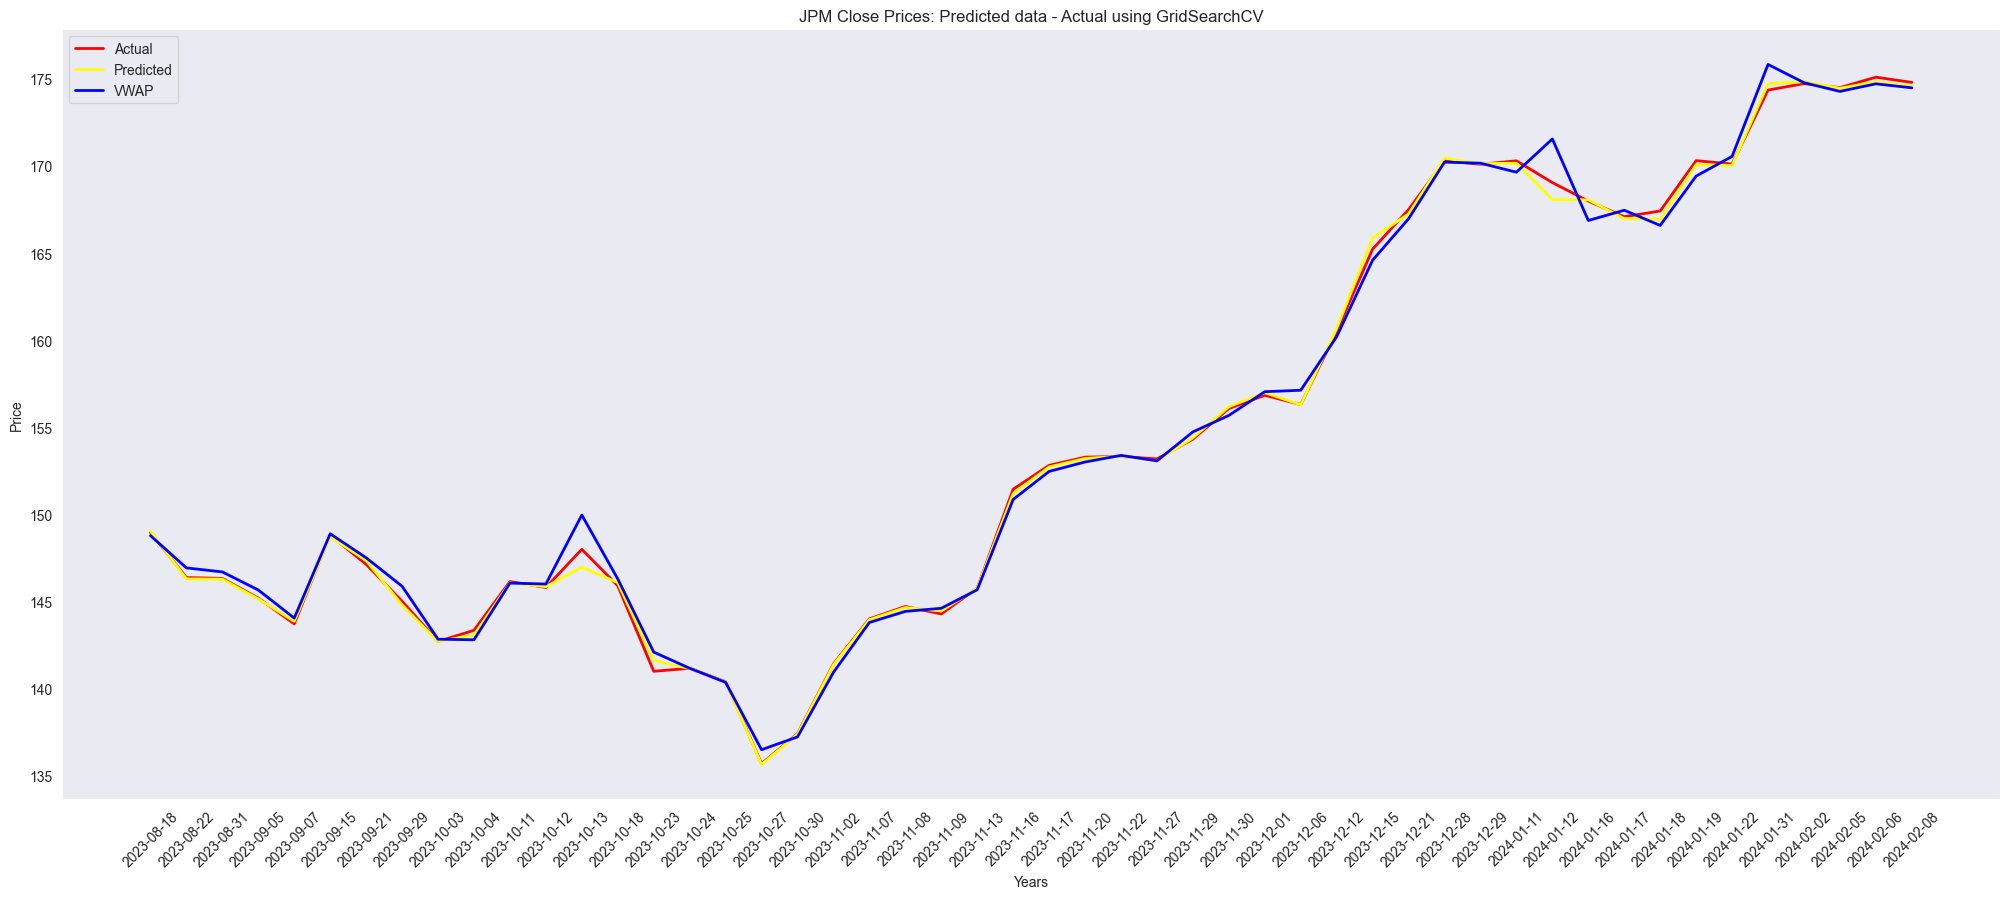

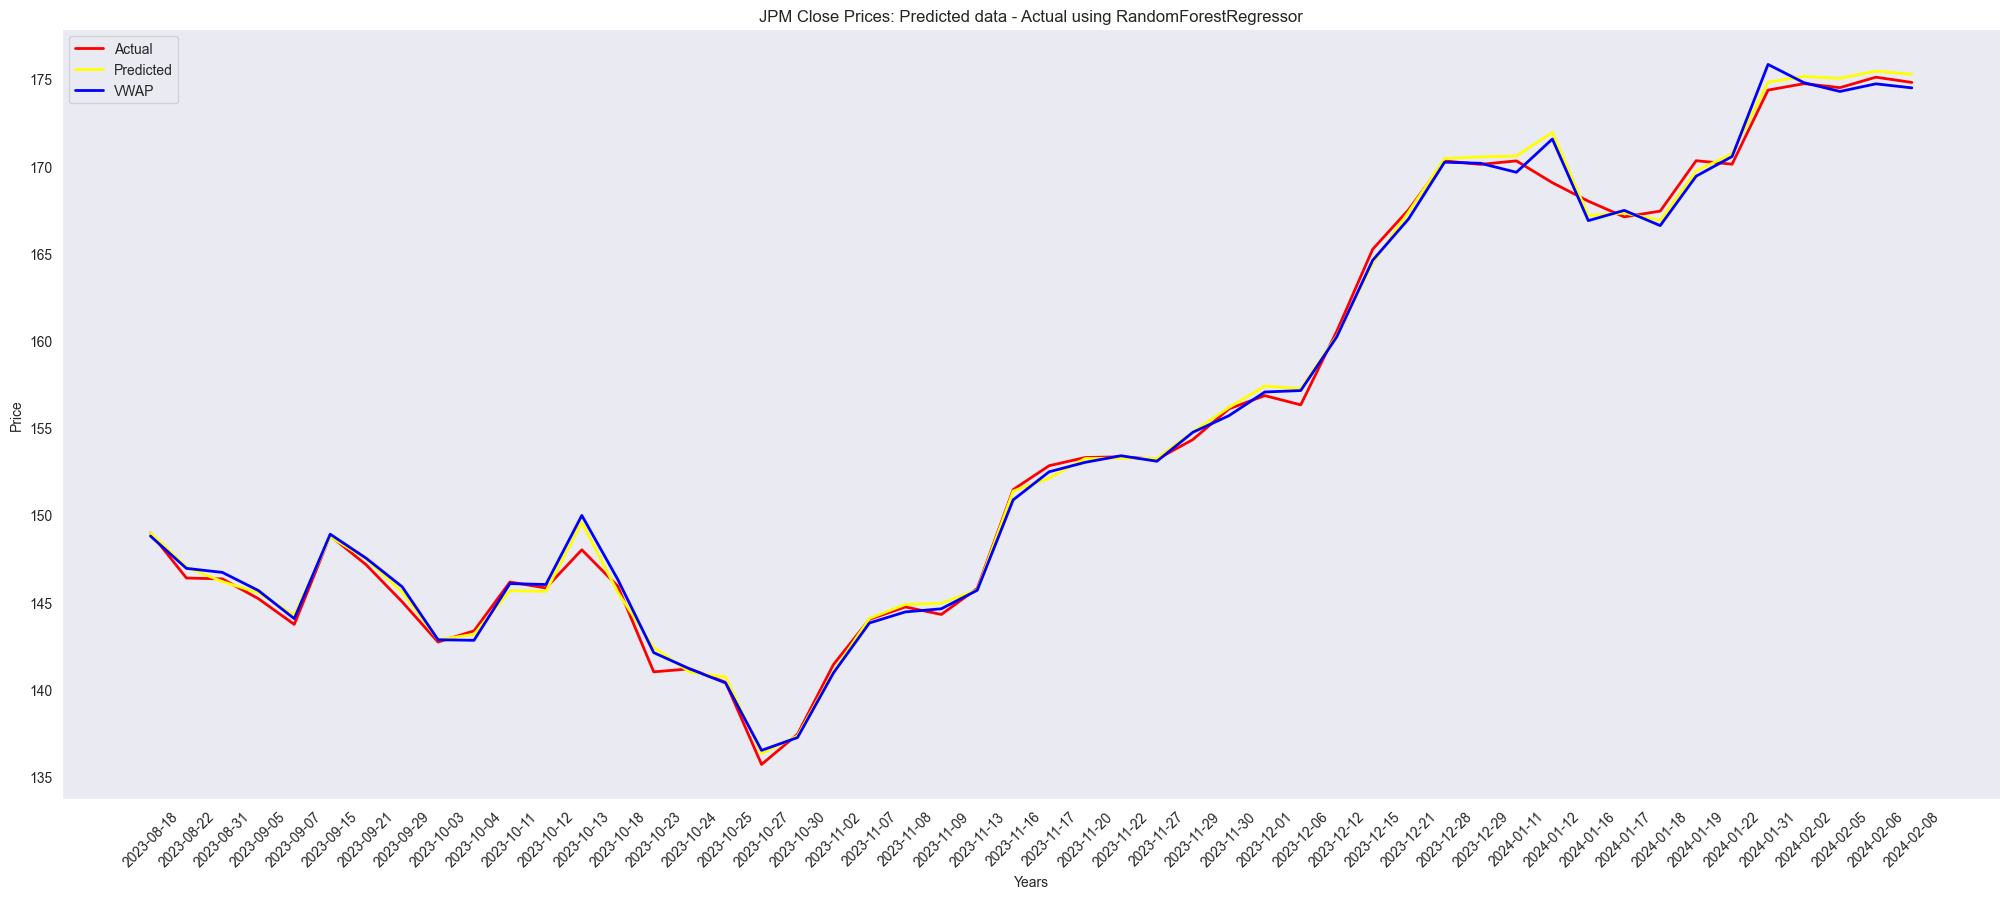

In [48]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_corr_train, X_corr_val, y_corr_train, y_corr_val)